In [1]:
import tarfile, tensorflow as tf, matplotlib.pyplot as plt, operator, random, pickle, glob, os, bcolz
import numpy as np
from keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.models import Model, Sequential


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
Using TensorFlow backend.


In [2]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [3]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [4]:
arr_lr = bcolz.open('trn_resized_72.bc')[0:1200]
arr_hr = bcolz.open('trn_resized_288.bc')[0:1200]

In [5]:
print(arr_hr.shape)

(1200, 288, 288, 3)


In [6]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(filters, (size, size), strides=stride, padding=mode)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x) if act else x

In [7]:
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return Add()([x, ip])

In [8]:
def up_block(x, filters, size):
    x = UpSampling2D()(x)
    x = Convolution2D(filters, (size, size), padding='same')(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

In [9]:
def get_model(arr):
    inp=Input(arr.shape[1:])
    x=conv_block(inp, 64, 9, (1,1))
    for i in range(4): x=res_block(x)
    x=up_block(x, 64, 4)
    x=up_block(x, 64, 4)
    x=Conv2D(3, (9, 9), activation="tanh", padding="same")(x)
    outp=Lambda(lambda x: (x+1)*127.5)(x)
    return inp,outp

In [10]:
arr_lr.shape[1:]

(72, 72, 3)

In [11]:
upsampled_inp,upsampled_output = get_model(arr_lr)

In [12]:
up_model2 = Model(upsampled_inp,upsampled_output)
up_model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 72, 72, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 72, 72, 64)   15616       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 72, 72, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 72, 72, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [13]:
shp = arr_hr.shape[1:]

vgg_inp=Input(shp)
vgg= VGG16(include_top=False,weights='imagenet', input_tensor=Lambda(preproc)(vgg_inp))
for l in vgg.layers: l.trainable=False

In [14]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 288, 288, 3)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 288, 288, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 288, 288, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 288, 288, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 144, 144, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 144, 144, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 144, 144, 128)     147584    
__________

In [15]:
preproc_layer = Lambda(preproc)

In [16]:
# get the vgg output 
vgg_out_layer = vgg.get_layer('block5_conv3').output

# making model Model(inputs, outputs)
vgg_content = Model(vgg_inp, vgg_out_layer)

vgg_content.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 288, 288, 3)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 288, 288, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 288, 288, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 288, 288, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 144, 144, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 144, 144, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 144, 144, 128)     147584    
__________

In [17]:
# this is the VGG model with the HR input
vgg_hr_image = vgg_content(preproc_layer(vgg_inp))

# this is the upsampled network
vgg_it_op = vgg_content(preproc_layer(upsampled_output))

In [18]:
loss = Lambda(lambda x: x[0]-x[1])([vgg_it_op,vgg_hr_image])

In [19]:
sr_model = Model([upsampled_inp, vgg_inp], loss)
sr_model.compile('adam', 'mse')

In [20]:
sr_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 72, 72, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 72, 72, 64)   15616       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 72, 72, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 72, 72, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [21]:
targ = np.zeros((arr_hr.shape[0], 18, 18, 512) )
sr_model.load_weights("super-resolution-train.hdf")

In [22]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='loss', patience=5, mode='min')
save_best = ModelCheckpoint('super-resolution-train.hdf', save_best_only=True, 
                           monitor='loss', mode='min')
sr_model.fit([arr_lr, arr_hr], targ, 32, 100, callbacks=[early_stopping,save_best])

Epoch 1/100
1200/1200 [==============================] - 210s 175ms/step - loss: 34.9714
Epoch 2/100
1200/1200 [==============================] - 188s 157ms/step - loss: 33.4441
Epoch 3/100
1200/1200 [==============================] - 186s 155ms/step - loss: 32.9929
Epoch 4/100
1200/1200 [==============================] - 184s 153ms/step - loss: 32.2936
Epoch 5/100
1200/1200 [==============================] - 184s 153ms/step - loss: 31.7937
Epoch 6/100
1200/1200 [==============================] - 184s 153ms/step - loss: 31.7308
Epoch 7/100
1200/1200 [==============================] - 184s 153ms/step - loss: 31.0177
Epoch 8/100
1200/1200 [==============================] - 184s 153ms/step - loss: 30.8393
Epoch 9/100
1200/1200 [==============================] - 184s 153ms/step - loss: 30.2239
Epoch 10/100
1200/1200 [==============================] - 183s 153ms/step - loss: 29.8870
Epoch 11/100
1200/1200 [==============================] - 184s 153ms/step - loss: 29.7979
Epoch 12/100
1200/1

KeyboardInterrupt: 

In [23]:
def get_model_1():
    inp=Input((None, None, 3))
    x=conv_block(inp, 64, 9, (1,1))
    for i in range(4): x=res_block(x)
    x=up_block(x, 64, 4)
    x=up_block(x, 64, 4)
    x=Conv2D(3, (9, 9), activation="tanh", padding="same")(x)
    outp=Lambda(lambda x: (x+1)*127.5)(x)
    return inp,outp

In [24]:
up_model2.save_weights('super-resolution.h5')

In [25]:
in_,out = get_model_1()
up_model= Model(in_,out)

In [26]:
up_model.load_weights('super-resolution.h5')

In [27]:
from PIL import Image

img = Image.open("test.jpg")
pred_img = np.expand_dims(np.array(img), axis=0)
new_p = up_model.predict(pred_img)



In [32]:
new_p = up_model.predict(np.expand_dims(bcolz.open('trn_resized_72.bc')[1232], axis=0))

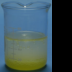

In [37]:
Image.fromarray(bcolz.open('trn_resized_72.bc')[1232].astype('uint8'))

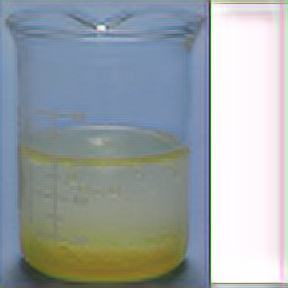

In [33]:
Image.fromarray(new_p[0].astype('uint8'))